In [1]:
import jax.numpy as jnp
import numpy as np
import jax
jax.config.update("jax_enable_x64", True)
from astropy.io import fits
import tqdm

from matplotlib import rc
import matplotlib.pyplot as plt
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import cmasher as cm

import load_data as ld
import optimise as opt
import scatters as opt_sc
import init_latents as il
import kfold_cv as kf

In [2]:
file_name = '-giants-and-dwarfs'
spectra_dir_path = '../spec/spectra-reference-stars-APOGEE-giants-and-dwarfs-/'
file_path = '../data/master-APOGEE-giants-and-dwarfs-.fits'
spectra_data, label_data = ld.load_data(spectra_dir_path, file_path, file_name)

../spec/spectra-reference-stars-APOGEE-giants-and-dwarfs-/spectra_data-giants-and-dwarfs.dat
File already exists. Loading spectra data


28it [00:00, 92.18it/s]


Loaded data successfully


In [3]:
labels_teff = label_data['labels'][:,0]
labels_logg = label_data['labels'][:,1]
labels_feh = label_data['labels'][:,2]
labels_mgfe = label_data['labels'][:,6]
labels_vmicro = label_data['labels'][:,12]
labels_vsini = label_data['labels'][:,13]
label_data_small = jnp.vstack((labels_teff, labels_logg, labels_feh, labels_mgfe, labels_vmicro, labels_vsini)).T

In [4]:
labels_teff_err = label_data['labels_err'][:,0]
labels_logg_err = label_data['labels_err'][:,1]
labels_feh_err = label_data['labels_err'][:,2]
labels_mgfe_err = label_data['labels_err'][:,6]
labels_vmicro_err = label_data['labels_err'][:,12]
labels_vsini_err = label_data['labels_err'][:,13]
label_data_small_err = jnp.vstack((labels_teff_err, labels_logg_err, labels_feh_err, labels_mgfe_err, labels_vmicro_err, labels_vsini_err)).T

In [5]:
labels_teff_ivars = label_data['labels_ivars'][:,0]
labels_logg_ivars = label_data['labels_ivars'][:,1]
labels_feh_ivars = label_data['labels_ivars'][:,2]
labels_mgfe_ivars = label_data['labels_ivars'][:,6]
labels_vmicro_ivars = label_data['labels_ivars'][:,12]
labels_vsini_ivars = label_data['labels_ivars'][:,13]

label_data_small_ivars = jnp.vstack((labels_teff_ivars, labels_logg_ivars, labels_feh_ivars, labels_mgfe_ivars, labels_vmicro_ivars, labels_vsini_ivars)).T

In [6]:
n = 4000
f = 1000

train_ID = label_data['ids'][:n]
train_flux = spectra_data['fluxes'][:n]
train_flux_err = spectra_data['fluxes_err'][:n]
train_flux_ivar = spectra_data['fluxes_ivars'][:n]
train_label = label_data_small[:n]
train_label_err = label_data_small_err[:n]
train_label_ivar = label_data_small_ivars[:n]

test_ID = label_data['ids'][n:]
test_flux = spectra_data['fluxes'][n:]
test_flux_err = spectra_data['fluxes_err'][n:]
test_flux_ivar = spectra_data['fluxes_ivars'][n:]
test_label = label_data_small[n:]
test_label_err = label_data_small_err[n:]
test_label_ivars = label_data_small_ivars[n:]

In [7]:
P = 49
alphas, betas, zetas = il.initialise_alphas_betas_zetas(train_label, train_flux, P)
alphas.shape, betas.shape, zetas.shape

((6, 49), (8575, 49), (4000, 49))

In [8]:
niter = 5
alphas_iter = jnp.zeros((niter,) + alphas.shape)
betas_iter = jnp.zeros((niter,) + betas.shape)
zetas_iter = jnp.zeros((niter,) + zetas.shape)
diff_chi2_iter = jnp.zeros((niter))
chi2_iter = jnp.zeros((niter))

omega = 1.
for iter in tqdm.tqdm_notebook(range(niter)):
    alphas, betas, zetas, diff_chi2, chi2 = opt.run_agenda(alphas, betas, zetas, train_label, train_label_err, train_flux, train_flux_err, omega)
    alphas_iter = alphas_iter.at[iter].set(alphas)
    betas_iter = betas_iter.at[iter].set(betas)
    zetas_iter = zetas_iter.at[iter].set(zetas)
    diff_chi2_iter = diff_chi2_iter.at[iter].set(diff_chi2)
    chi2_iter = chi2_iter.at[iter].set(chi2)

/var/folders/rq/q7l_wtbx4sx5ky0yrvbk7fgh0000gq/T/ipykernel_93301/141839097.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for iter in tqdm.tqdm_notebook(range(niter)):


  0%|          | 0/5 [00:00<?, ?it/s]

In [1]:
name = '_P49_omega1-train-highsnrallstars'
savepath = '../sav/paper/'

np.save(savepath+'alphas_giants'+str(name), alphas_iter)
np.save(savepath+'betas_giants'+str(name), betas_iter)
np.save(savepath+'diff_chi2_giants'+str(name), diff_chi2_iter)
np.save(savepath+'chi2_giants'+str(name), chi2_iter)
np.save(savepath+'zetas_train_giants'+str(name), zetas_iter)

plt.figure(figsize=(7,5), constrained_layout=True)

plt.plot(chi2_iter, color='navy', lw=3)
plt.ylabel('$\chi^{2}$', fontsize=20)
plt.xlabel('Iteration $\#$', fontsize=20)
plt.yscale('log')
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.savefig('../plots/paper/chi2_giants'+str(name)+'.pdf',dpi=200, bbox_inches = 'tight')

NameError: name 'np' is not defined

In [19]:
name = '_P49_omega1-train-highsnrallstars'
savepath = '../sav/paper/'

alphas_iter = np.load(savepath+'alphas_giants'+str(name)+'.npy', allow_pickle=True)
betas_iter = np.load(savepath+'betas_giants'+str(name)+'.npy', allow_pickle=True)
zetas_iter = np.load(savepath+'zetas_train_giants'+str(name)+'.npy', allow_pickle=True)

alphas = alphas_iter[-1, : , :]
betas = betas_iter[-1, : , :]
zetas = zetas_iter[-1, : , :]

In [22]:
ln_noise_fluxes_init = jnp.full(train_flux.shape[1], -8.0)
l2_reg_strength = 1000
omega=1

In [23]:
# run optimisation routine with noise in the flux
betas_updated, zetas_updated, ln_noise_fluxes_updated, nll_updated = opt_sc.run_agenda(alphas, betas, zetas, train_label, train_label_ivar, train_flux, train_flux_ivar,\
                                            ln_noise_fluxes_init, l2_reg_strength, omega)

INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 25154620.415873192, Curvature error: 27024372458142.82
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 523362.41788173874, Curvature error: 561991066129.5449


In [24]:
name = '_P49_L2regstrength1000_omega1-train-highsnrallstars'
savepath = '../sav/paper/'

np.save(savepath+'alphas_giants-withscatters'+str(name), alphas)
np.save(savepath+'betas_giants-withscatters'+str(name), betas_updated)
np.save(savepath+'zetas_train_giants-withscatters'+str(name), zetas_updated)
np.save(savepath+'noise_fluxes_train_giants-withscatters'+str(name), jnp.exp(ln_noise_fluxes_updated))
np.save(savepath+'nll_train_giants-withscatters'+str(name),nll_updated)

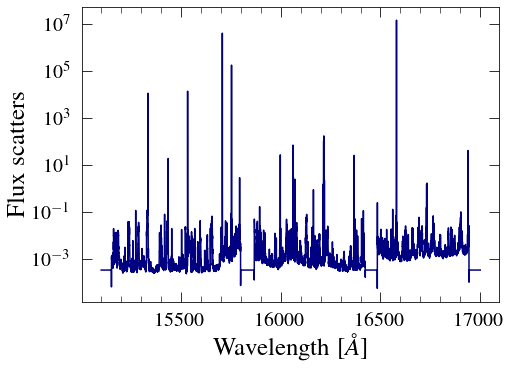

In [25]:

plt.figure(figsize=(7,5), constrained_layout=True)

plt.plot(spectra_data['wl'], jnp.exp(ln_noise_fluxes_updated), color='navy')
plt.ylabel('Flux scatters', fontsize=25)
plt.xlabel('Wavelength [$\AA$]', fontsize=25)
plt.yscale('log')
# plt.ylim(0,0.02)
plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.savefig('../plots/paper/noise_fluxes_train_giants'+str(name)+'.pdf',dpi=200, bbox_inches = 'tight')